In [1]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import os
PROJ_ROOT = os.path.join(os.pardir)

df_path = os.path.join(PROJ_ROOT, 
                         'data',
                          'topics_data_4_topics.csv')
data_path=os.path.join(PROJ_ROOT, 
                         'data')

from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob

In [2]:
full_data = pd.read_csv(df_path)
full_data['created_at'] = pd.to_datetime(full_data['created_at'])

In [3]:
full_data=full_data.drop_duplicates(['user_id','full_text'])

In [4]:
def vader_sent_df(df=full_data):
    '''Returns a new df with VADER sentiment scores'''
    
    s_vader=SentimentIntensityAnalyzer() #instantiate Analyzer
    
    #create a list of scores for each tweet
    sent_scores = [s_vader.polarity_scores(sent) for sent in tqdm(df.full_text)]
    
    #Add each emotion (positive, negative & compound) scores to the dataframe
    for emotion in sent_scores[0].keys():
        df[emotion+'_sentiment'] = [x[emotion] for x in tqdm(sent_scores)]
    
#     df.index.rename('created_at',inplace=True)
#     df=df.reset_index() #reset the index
    
    return df

def plot_vader_sent(df, title='all'):
    '''Plot the sentiment scores '''
    date_ranges=pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
    date_ranges=date_ranges.strftime('%m-%d-%Y') # reformat
    # create a list of each emotion
    vals = df.pos_sentiment.tolist()
    n_vals = [x*-1 for x in df.neg_sentiment.tolist()]
    c_vals = df.compound_sentiment.tolist()
    

    #plot the moving averages
    xmin = max(date_ranges)
    xmax = min(date_ranges)
    plt.figure(figsize=(15, 10)) 
    plt.plot(date_ranges,vals, color='blue', alpha=.3, label='positive')
    plt.plot(n_vals,color='red', alpha=.3, label='negative')
    plt.plot(c_vals,color='green', label='compound')
#     plt.hlines(.05, xmin, xmax, linestyles = 'dotted', label='positive')
#     plt.hlines(-.05,xmin,xmax,linestyles = 'dotted', label='negative')
    plt.axhspan(-.05,.05,xmin,xmax, color='grey', alpha=.2,label='neutral')

    
    # label the plot and show
    plt.xlabel('Tweets')
    plt.ylabel('Sentiment Score')
    plt.title('Sentiment Score Across Time for {} data'.format(title))
    plt.grid(which='major',axis='x')
    plt.legend()
    plt.show()
    plt.savefig('sent_over_time.png', bbox_inches='tight')


In [5]:
full_data.head()

,created_at,level_0,index,tweet_id,full_text,geo,coordinates,place,retweet_count,favorite_count,...,text,rating,topic_title,other,covid_updates,opinion,vaccine_updates,dominant_topic,topic_perc_contrib,keywords
0,2021-02-23 14:38:16+00:00,0,0,1.364223e+18,Here’s what's in the COVID relief package:\n \...,NaN,NaN,NaN,9160,38093,...,Here’s what's in the COVID relief package:\n \...,222,Opinion,0.009347,0.009342,0.971633,0.009679,2.0,0.9716,"coronavirus, vaccine, vaccinate, people, pande..."
1,2021-02-24 01:07:52+00:00,1,1,1.364381e+18,Will the National Endowment for the Arts be he...,NaN,NaN,NaN,6131,18560,...,Will the National Endowment for the Arts be he...,17141,Vaccine Updates,0.017380,0.017220,0.464710,0.500691,3.0,0.5012,"coronavirus, vaccine, dose, pfizer, vaccinatio..."
2,2021-02-24 16:14:15+00:00,2,2,1.364610e+18,"This is both anecdotal and early, but many lon...",NaN,NaN,NaN,5941,63174,...,"This is both anecdotal and early, but many lon...",24308,Opinion,0.019351,0.019368,0.510466,0.450815,2.0,0.5104,"coronavirus, vaccine, vaccinate, people, pande..."
3,2021-02-24 23:59:58+00:00,3,3,1.364727e+18,A Link to Professor Chossudovsky’s Analysis of...,NaN,NaN,NaN,1,0,...,A Link to Professor Chossudovsky’s Analysis of...,22163,Opinion,0.017147,0.183378,0.590712,0.208763,2.0,0.5907,"coronavirus, vaccine, vaccinate, people, pande..."
4,2021-02-24 23:59:58+00:00,4,4,1.364727e+18,Children warned over hugging grandparents even...,NaN,NaN,NaN,0,2,...,Children warned over hugging grandparents even...,2168,Opinion,0.012068,0.012074,0.963291,0.012566,2.0,0.9633,"coronavirus, vaccine, vaccinate, people, pande..."


In [6]:
#add sentiment analysis to the dataframe
tweet_sent=vader_sent_df()

<ipython-input-4-313ccd9f0773>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  sent_scores = [s_vader.polarity_scores(sent) for sent in tqdm(df.full_text)]


  0%|          | 0/46324 [00:00<?, ?it/s]

<ipython-input-4-313ccd9f0773>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  df[emotion+'_sentiment'] = [x[emotion] for x in tqdm(sent_scores)]


  0%|          | 0/46324 [00:00<?, ?it/s]

  0%|          | 0/46324 [00:00<?, ?it/s]

  0%|          | 0/46324 [00:00<?, ?it/s]

  0%|          | 0/46324 [00:00<?, ?it/s]

In [7]:
tweet_sent['created_at'] = pd.to_datetime(tweet_sent['created_at'])

In [8]:
from collections import defaultdict



def aggregate_by_day(df):
        date_ranges=pd.date_range(start=df.created_at.min(), end=df.created_at.max(), freq='D')
        date_ranges=date_ranges.strftime('%m-%d-%Y') # reformat
        tweets_by_day=defaultdict(list)
        df=df.set_index('created_at')
        for day in date_ranges:
            tweets_by_day[day].append(df.loc[day].full_text.tolist())
        
        return tweets_by_day


In [9]:
#aggreagate all the tweet text by day
tweets_by_day=aggregate_by_day(full_data)
for day,tweets in tweets_by_day.items():
    tweets_by_day[day]=[text for tweet in tweets for text in tweet]
    tweets_by_day[day]= ''.join(tweets_by_day[day][0])
    
tweets_by_day = pd.DataFrame.from_dict(tweets_by_day, orient='index', columns=['full_text'])

In [10]:
tweets_by_day.head()

,full_text
02-22-2021,If there’s one message I want to cut through t...
02-23-2021,Here’s what's in the COVID relief package:\n \...
02-24-2021,Will the National Endowment for the Arts be he...
02-25-2021,"Six weeks ago, 14% of people over 75 in the US..."
02-26-2021,Tell me why I’ve received multiple emails and ...


In [11]:
#add sentiment analysis to the dataframe
tweet_sent_day=vader_sent_df(df=tweets_by_day)
tweet_sent_day.index=tweets_by_day.index

<ipython-input-4-313ccd9f0773>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  sent_scores = [s_vader.polarity_scores(sent) for sent in tqdm(df.full_text)]


  0%|          | 0/9 [00:00<?, ?it/s]

<ipython-input-4-313ccd9f0773>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  df[emotion+'_sentiment'] = [x[emotion] for x in tqdm(sent_scores)]


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [12]:
tweet_sent_day.to_csv('sentiment_by_day_8t.csv')

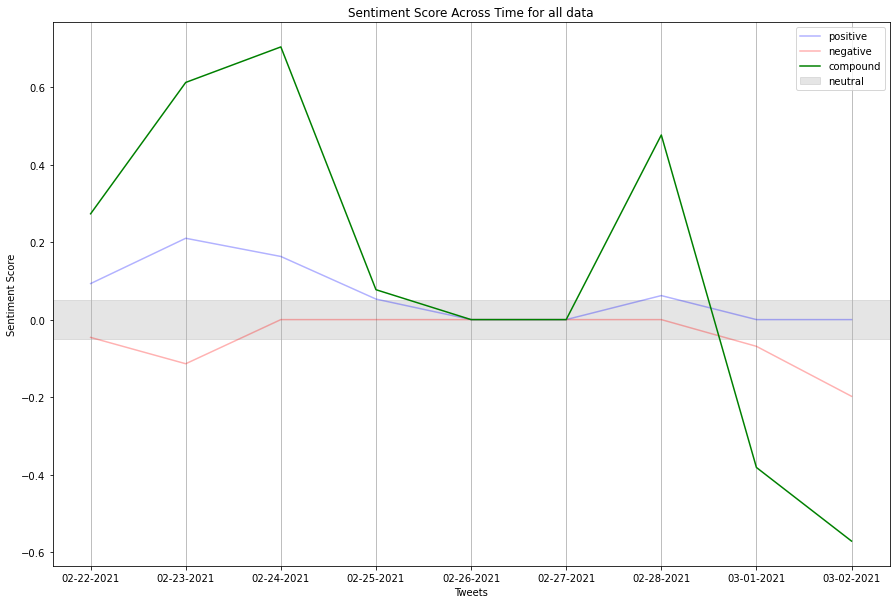

<Figure size 432x288 with 0 Axes>

In [13]:
plot_vader_sent(tweet_sent_day)

In [14]:
def df_plot_by_topic(df):

    for title in df.topic_title.unique():
        print(title)
        tmp=df[df.topic_title==title]

        #aggreagate all the tweet text by day
        tweets_by_day=aggregate_by_day(tmp)
        
        for day,tweets in tweets_by_day.items():
            tweets_by_day[day]=[text for tweet in tweets for text in tweet]
            tweets_by_day[day]= ''.join(tweets_by_day[day][0])


        tweets_by_day = pd.DataFrame.from_dict(tweets_by_day, orient='index', columns=['full_text'])
        

        #add sentiment analysis to the dataframe
        tweet_sent_day=vader_sent_df(df=tweets_by_day)
        tweet_sent_day.to_csv('sentiment_by_topic_by_day_8t.csv')

        plot_vader_sent(tweet_sent_day,title)



Opinion


<ipython-input-4-313ccd9f0773>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  sent_scores = [s_vader.polarity_scores(sent) for sent in tqdm(df.full_text)]


  0%|          | 0/9 [00:00<?, ?it/s]

<ipython-input-4-313ccd9f0773>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  df[emotion+'_sentiment'] = [x[emotion] for x in tqdm(sent_scores)]


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

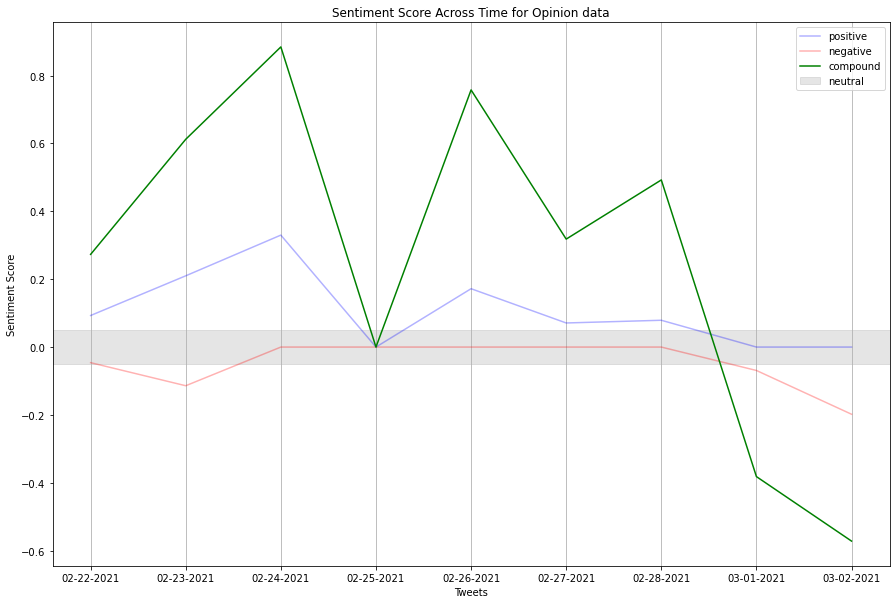

Vaccine Updates


<ipython-input-4-313ccd9f0773>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  sent_scores = [s_vader.polarity_scores(sent) for sent in tqdm(df.full_text)]


  0%|          | 0/9 [00:00<?, ?it/s]

<ipython-input-4-313ccd9f0773>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  df[emotion+'_sentiment'] = [x[emotion] for x in tqdm(sent_scores)]


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

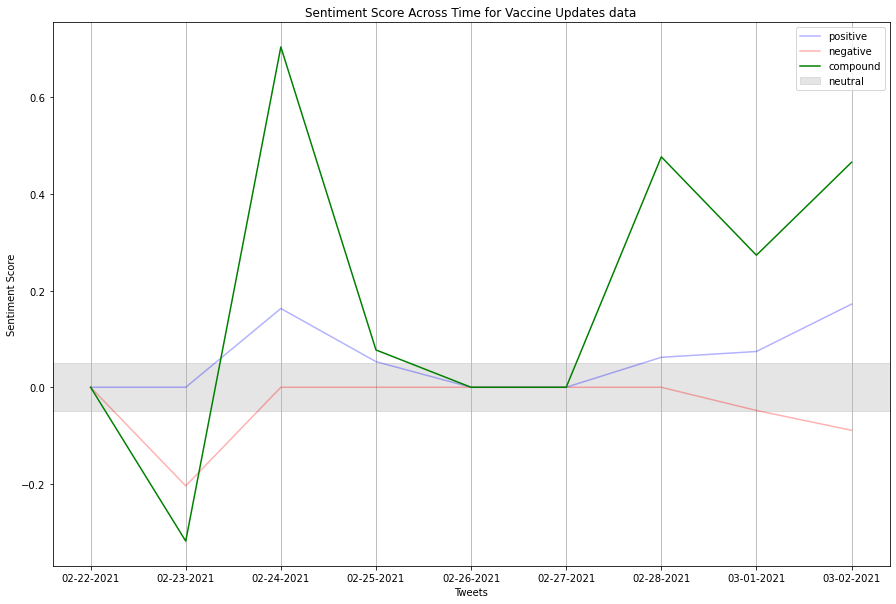

Other


<ipython-input-4-313ccd9f0773>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  sent_scores = [s_vader.polarity_scores(sent) for sent in tqdm(df.full_text)]


  0%|          | 0/9 [00:00<?, ?it/s]

<ipython-input-4-313ccd9f0773>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  df[emotion+'_sentiment'] = [x[emotion] for x in tqdm(sent_scores)]


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

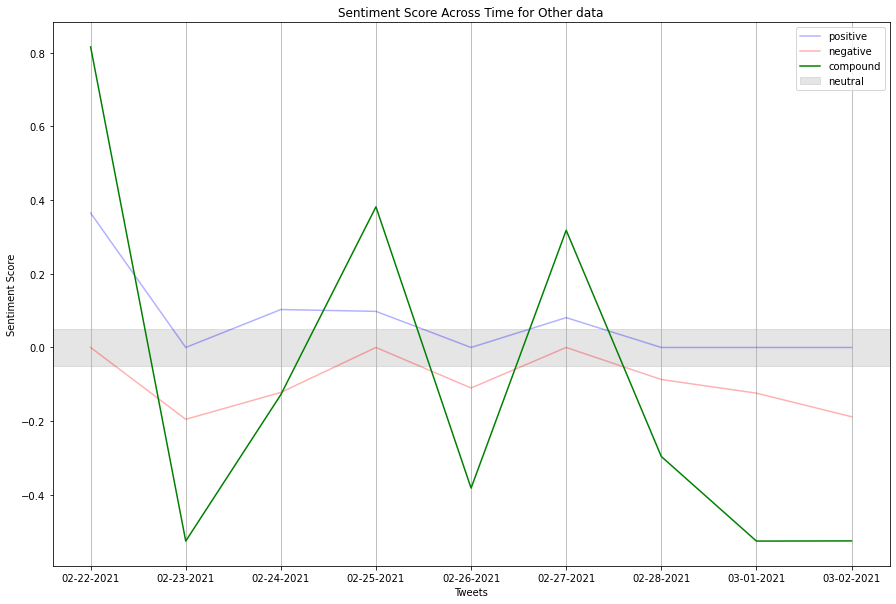

Covid Updates


<ipython-input-4-313ccd9f0773>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  sent_scores = [s_vader.polarity_scores(sent) for sent in tqdm(df.full_text)]


  0%|          | 0/8 [00:00<?, ?it/s]

<ipython-input-4-313ccd9f0773>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  df[emotion+'_sentiment'] = [x[emotion] for x in tqdm(sent_scores)]


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

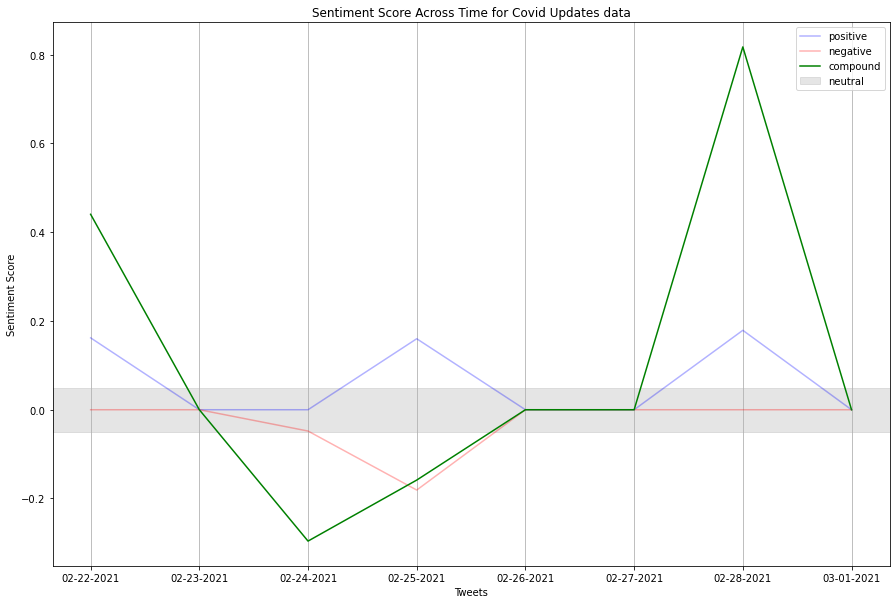

<Figure size 432x288 with 0 Axes>

In [15]:
df_plot_by_topic(full_data)

<AxesSubplot:xlabel='user_followers_count', ylabel='compound_sentiment'>

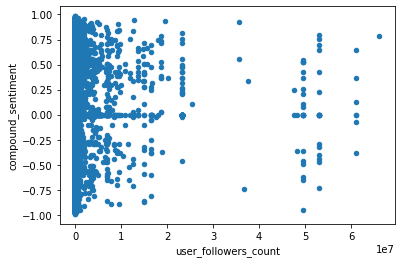

In [16]:
full_data[['compound_sentiment','user_followers_count']].plot.scatter('user_followers_count','compound_sentiment')

**user count & sentiment by topic**

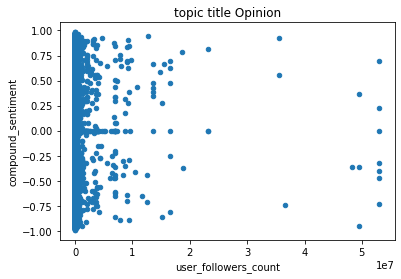

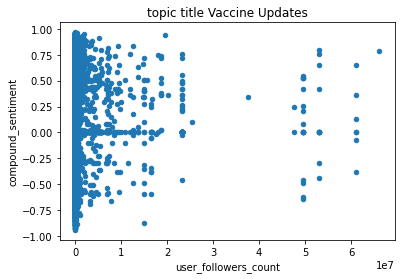

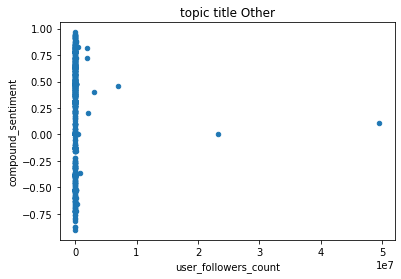

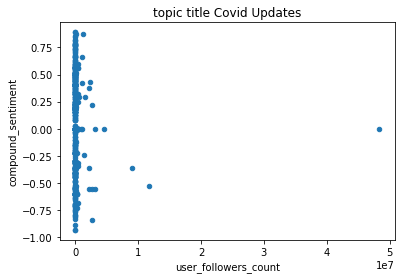

In [17]:
for topic in full_data.topic_title.unique():
    full_data[full_data.topic_title==topic][['compound_sentiment','user_followers_count']].plot.scatter('user_followers_count','compound_sentiment')
    plt.title('topic title {}'.format(str(topic)))
    plt.show()


### Who were the most positive and negative twitter users with the most followers?

In [18]:
top_pos = full_data[['compound_sentiment','user_followers_count','user_id','full_text']]
top_pos = top_pos[(top_pos.user_followers_count>5000000) & (top_pos.compound_sentiment>.05)]
print('Top 5 positive tweets by those with the most followers')
[print(str(i+1)+'\n'+tweet+'\n-----\n') for i,tweet in enumerate(top_pos.sort_values(by='compound_sentiment',ascending=False)[:5].full_text.tolist()) ]
print('scores \n',top_pos.sort_values(by='compound_sentiment',ascending=False)[:5].compound_sentiment.tolist())
print('no of followers \n',top_pos.sort_values(by='compound_sentiment',ascending=False)[:5].user_followers_count.tolist())

print('Twitter Ids')
top_pos.sort_values(by='compound_sentiment',ascending=False)[:5].user_id.tolist()

Top 5 positive tweets by those with the most followers
1
India handled Covid better than many other countries.
India will now  handle vaccination better than many other countries.

All the best to all Indians as we enter the next phase of vaccination!

Stay healthy. Stay compassionate. When it's your turn, get your vaccine!
-----

2
बस हो गया! 

The first dosage of COVID-19 vaccine was administered to me at RR Hospital today.

India’s resolve for making the country COVID free has been strengthened by this inoculation drive. The Vaccine is completely safe and hassle free. 
#LargestVaccineDrive https://t.co/sKsrtLeGqi
-----

3
Hope everyone is alright! Had my wisdom teeth out recently, ruthless stuff! I'll be on in a few days. Sending you all love
-----

4
About 2.5 million women have been forced out of the workforce during the pandemic. The American Rescue Plan provides relief to women and families with $1,400 payments, a $3,000 child tax credit, and funding to safely reopen schools and

[44588485.0, 1346439824.0, 84279963.0, 8.036941790794588e+17, 355989081.0]

Those 5 Twitter users:<br>
ID Conversions from https://tweeterid.com/:<br><br>
44588485 => @chetan_bhagat<br>
Chetan Bhagat is an Indian author and columnist. He was included in Time magazine's list of World's 100 Most Influential People in 2010. <br><br>
1346439824 => @rajnathsingh<br>
Rajnath Singh is an Indian politician serving as the Defence Minister of India. He is the former President of Bharatiya Janata Party.<br><br>
84279963 => @Louis_Tomlinson<br>
Louis William Tomlinson is an English singer and songwriter. He rose to fame as a member of the boy band One Direction. <br><br>
803694179079458816 => @VP
The vice president of the United States <br><br> 
355989081 => @ANI<br>
Asian News International is an Indian news agency that offers syndicated multimedia news feed to multiple news-bureaus in India and beyond. 

In [19]:
top_neg = full_data[['compound_sentiment','user_followers_count','user_id','full_text']]
top_neg = top_neg[(top_neg.user_followers_count>4000000) & (top_neg.compound_sentiment<-.05)]
print('Top 5 positive tweets by those with the most followers')
[print(str(i+1)+'\n'+tweet+'\n-----\n') for i,tweet in enumerate(top_neg.sort_values(by='compound_sentiment',ascending=True)[:6].full_text.tolist()) ]
print('scores \n',top_neg.sort_values(by='compound_sentiment',ascending=True)[:6].compound_sentiment.tolist())
print('no of followers \n',top_neg.sort_values(by='compound_sentiment',ascending=True)[:6].user_followers_count.tolist())

print('Twitter Ids')
top_neg.sort_values(by='compound_sentiment',ascending=True)[:6].user_id.tolist()

Top 5 positive tweets by those with the most followers
1
Attacks against Asian-Americans in New York City have soared since the pandemic began, terrifying many and stoking fears of targeted violence. The xenophobia is also compounded by the economic fallout of the pandemic and fears of the coronavirus.
https://t.co/9sbMfgQWzv
-----

2
How annoying that the Brazil variant snuck into Britain during the many weeks we knew about it but didn’t shut our border. 
Damn that virus for not respecting our Govt’s right to dither and delay.
-----

3
One year ago today, Kayleigh McEnany made a really bad COVID prediction, but what's really special is how she also made a bad terrorism prediction in the same sentence https://t.co/yIjgHFMm3K
-----

4
@AP The FDA said J&amp;J’s vaccine offers strong protection against what matters most: serious illness, hospitalizations and death. One dose was 85% protective against the most severe COVID-19 illness, in a massive study that spanned three continents. http

[807095.0, 216299334.0, 158414847.0, 51241574.0, 7587032.0, 51241574.0]

Those 5 Twitter users:<br><br>
807095 => @nytimes<br>
51241574 => @AP<br>
216299334 => @piersmorgan<br>
Piers Stefan Pughe-Morgan is an English broadcaster, journalist, writer, and television personality. <br>
158414847 => @TheDailyShow<br>
51241574 => @AP<br><br>

This does not track well for negative sentiments.<br>
- Most are news outlets<br>
- Results may be different if subjectiviiy is taken into account, some of these are covid updates on deaths, illness etc. Which are counted as a negative sentiment.<br>
- Sentiment can be re-run with these keywords removed to get a better sense of the sentiment<br><br>

Sentiment via a NN may be better option for this dat

In [20]:
# functions to determine sentiment based on intensity/subjectivity scores for TextBlob

def sent_scores(row):
  subj = row['tb_score']
  if row['compound_sent'] < .05 and row['compound_sent'] > -.05:
    return 'neu'
  elif row['neg_sent'] < .2 and row['pos_sent'] - row['neg_sent'] > 0:
        return 'pos'
  elif row['pos_sent'] < .2 and row['neg_sent'] - row['pos_sent'] > 0:
        return 'neg'
  else:
    return 'neu'

def sent_subj(row):
  subj = row['tb_score']
  if row['compound_sent'] < .05 and row['compound_sent'] > -.05:
    return 'neu'
  elif row['pos_sent'] - row['neg_sent'] > .05 and row['tb_subj']>.30 and row['neg_sent']>0 and row['compound_sent']>.5:
        return 'pos'
  elif row['neg_sent'] - row['pos_sent'] > .05 and row['tb_subj']>.30 and row['pos_sent']>0 and row['compound_sent']<-.5:
        return 'neg'
  else:
    return 'neu'

In [21]:
s_vader = SentimentIntensityAnalyzer() # instantiate the Analyzer

#process the VADER score for all tweets in the df
vader_score = [s_vader.polarity_scores(sent) for sent in tqdm(full_data.full_text)] 

#add each sentiment option as a column in the dataframe, and place the score for each for each sentence
for scores in vader_score[0].keys():
    full_data[scores+'_sent'] = [x[scores] for x in vader_score ]

<ipython-input-21-03a8f8c4dcf2>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  vader_score = [s_vader.polarity_scores(sent) for sent in tqdm(full_data.full_text)]


  0%|          | 0/46324 [00:00<?, ?it/s]

### textblob sentiment

In [22]:
#obtain the sentiment polarity & subjectivity scores for each tweet
tb_score = [TextBlob(sent).polarity for sent in tqdm(full_data.full_text)]
tb_sub_score = [TextBlob(sent).subjectivity for sent in tqdm(full_data.full_text)]

#place the polarity and subjectivity scores into the dataframe
full_data['tb_score']=tb_score
full_data['tb_subj']=tb_sub_score

<ipython-input-22-1b48cb5fcb02>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tb_score = [TextBlob(sent).polarity for sent in tqdm(full_data.full_text)]


  0%|          | 0/46324 [00:00<?, ?it/s]

<ipython-input-22-1b48cb5fcb02>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tb_sub_score = [TextBlob(sent).subjectivity for sent in tqdm(full_data.full_text)]


  0%|          | 0/46324 [00:00<?, ?it/s]

In [23]:
# add the TextBlob sentiment with the rules in the defined functions
full_data['tb_sent'] = full_data.apply(sent_scores, axis=1)
full_data['tb_sent_subj'] = full_data.apply(sent_subj, axis=1)
# add the VADER sentiment to the dataframef
full_data['v_sent'] = full_data.apply(lambda x: 'pos' if x['compound_sent']>=.05 else ('neg' if x['compound_sent']<=-.05 else 'neu'), axis=1)

## EDA with sentiment

### Sentiment scores by topic
Which topics had the most/least positive and negative sentiment?

In [24]:
sent_bytopic_dict = defaultdict(list)

sent_vals = {'neu','pos','neg'}

for x, topic in enumerate(full_data.topic_title.unique()):
    cnts = full_data[full_data.topic_title==topic].tb_sent_subj.value_counts(normalize=True)
    
    for idx in cnts.index:
        sent_bytopic_dict[idx+'_p'].append(cnts.loc[idx])
    
    if len(cnts.index)<3:
        for s in sent_vals.difference(set(cnts.index)):
            sent_bytopic_dict[s+'_p'].append(0)
    
    
    cnts = full_data[full_data.topic_title==topic].tb_sent_subj.value_counts()
    
    for idx in cnts.index:
        sent_bytopic_dict[idx].append(cnts.loc[idx])
    
    if len(cnts.index)<3:
        for s in sent_vals.difference(set(cnts.index)):
            sent_bytopic_dict[s].append(0)
    
    sent_bytopic_dict['topic'].append(topic)

In [25]:
sent_cnts_topic = pd.DataFrame.from_dict(sent_bytopic_dict)
display(sent_cnts_topic)
sent_cnts_topic.to_csv('sent_by_topic_total_8t.csv',index=False)

,neu_p,neg_p,pos_p,neu,neg,pos,topic
0,0.851615,0.078794,0.069591,21746,2012,1777,Opinion
1,0.958276,0.013760,0.027964,17271,248,504,Vaccine Updates
2,0.961462,0.011296,0.027243,1447,17,41,Other
3,0.977002,0.015067,0.007930,1232,19,10,Covid Updates


In [26]:
# sent_cnts_topic['topic']=sent_cnts_topic.topic.astype(str)

In [27]:
sent_cnts_topic['topic'] = sent_cnts_topic.topic.astype(str)

Text(-60.325, 0.5, 'Topic')

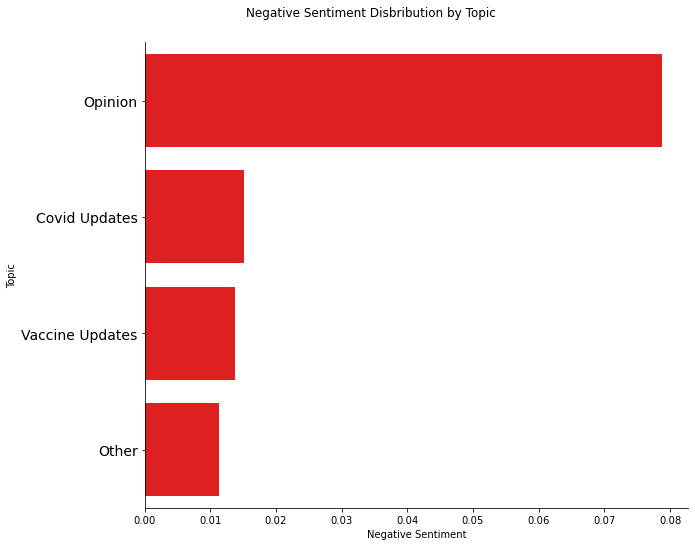

In [28]:
plot=sns.catplot(y='topic',
                 x='neg_p', 
                 kind='bar',
                 data = sent_cnts_topic.sort_values(by=['neg_p'],ascending=False), 
                 color='red', 
                 height=7,
                 aspect=1.3)
plot.set_yticklabels(fontsize=14)
plot.fig.suptitle('Negative Sentiment Disbribution by Topic', y=1.05)
plot.ax.set_xlabel('Negative Sentiment')
plot.ax.set_ylabel('Topic')
# fig.show()

Text(-60.325, 0.5, 'Topic')

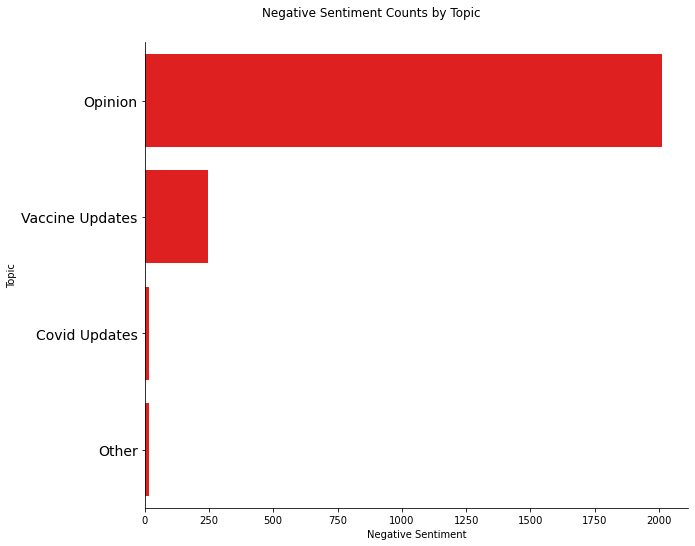

In [29]:
plot=sns.catplot(y='topic',
                 x='neg', 
                 kind='bar',
                 data = sent_cnts_topic.sort_values(by=['neg'],ascending=False), 
                 color='red', 
                 height=7,
                 aspect=1.3)
plot.set_yticklabels(fontsize=14)
plot.fig.suptitle('Negative Sentiment Counts by Topic', y=1.05)
plot.ax.set_xlabel('Negative Sentiment')
plot.ax.set_ylabel('Topic')

Text(-60.325, 0.5, 'Topic')

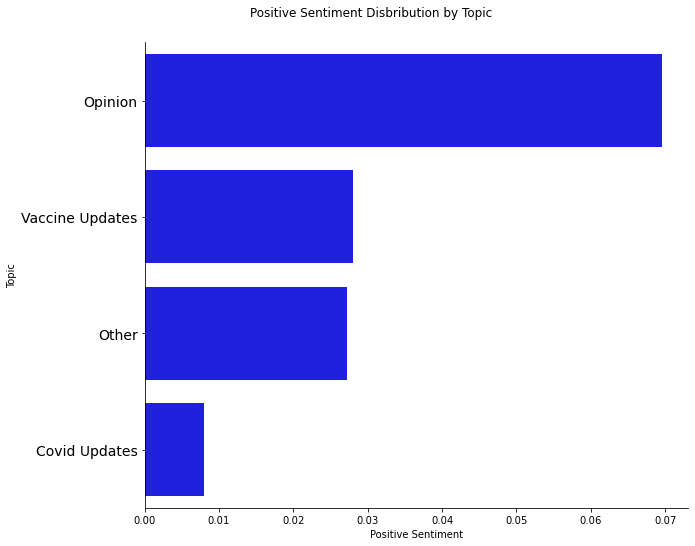

In [30]:
plot=sns.catplot(y='topic',
                 x='pos_p', 
                 kind='bar',
                 data = sent_cnts_topic.sort_values(by=['pos_p'],ascending=False), 
                 color='blue', 
                 height=7,
                 aspect=1.3)
plot.set_yticklabels(fontsize=14)
plot.fig.suptitle('Positive Sentiment Disbribution by Topic', y=1.05)
plot.ax.set_xlabel('Positive Sentiment')
plot.ax.set_ylabel('Topic')
# fig.show()

Text(-60.325, 0.5, 'Topic')

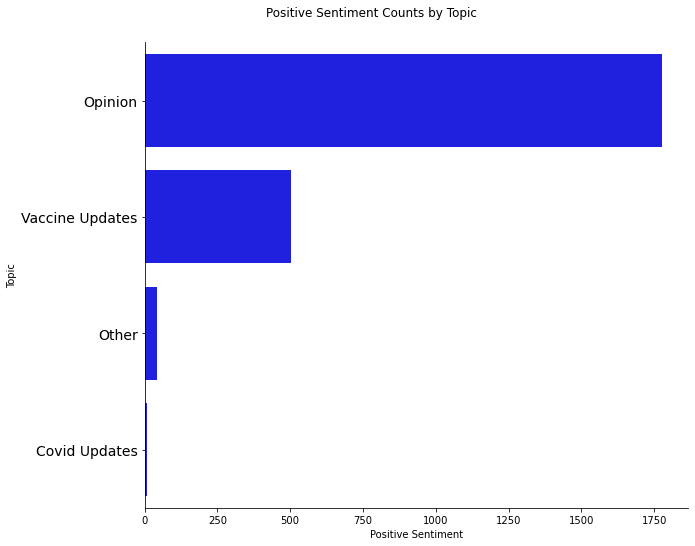

In [31]:
plot=sns.catplot(y='topic',
                 x='pos', 
                 kind='bar',
                 data = sent_cnts_topic.sort_values(by=['pos'],ascending=False), 
                 color='blue', 
                 height=7,
                 aspect=1.3)
plot.set_yticklabels(fontsize=14)
plot.fig.suptitle('Positive Sentiment Counts by Topic', y=1.05)
plot.ax.set_xlabel('Positive Sentiment')
plot.ax.set_ylabel('Topic')
# fig.show()

Text(-60.325, 0.5, 'Topic')

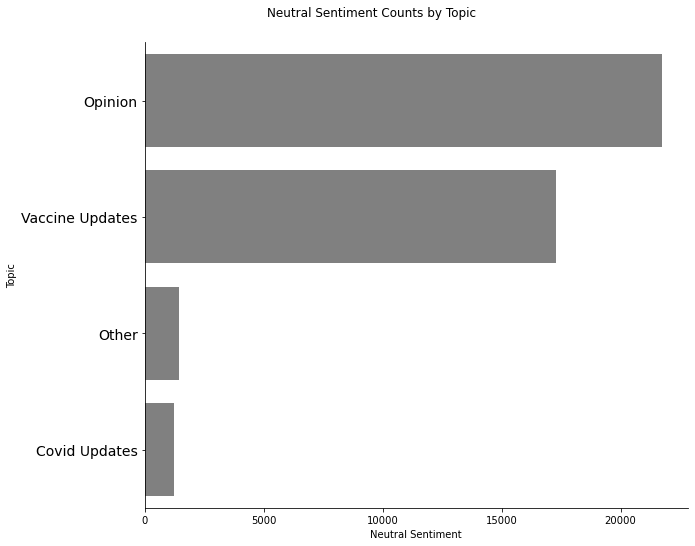

In [32]:
plot=sns.catplot(y='topic',
                 x='neu', 
                 kind='bar',
                 data = sent_cnts_topic.sort_values(by=['neu'],ascending=False), 
                 color='grey', 
                 height=7,
                 aspect=1.3)
plot.set_yticklabels(fontsize=14)
plot.fig.suptitle('Neutral Sentiment Counts by Topic', y=1.05)
plot.ax.set_xlabel('Neutral Sentiment')
plot.ax.set_ylabel('Topic')
# fig.show()

Text(-60.325, 0.5, 'Topic')

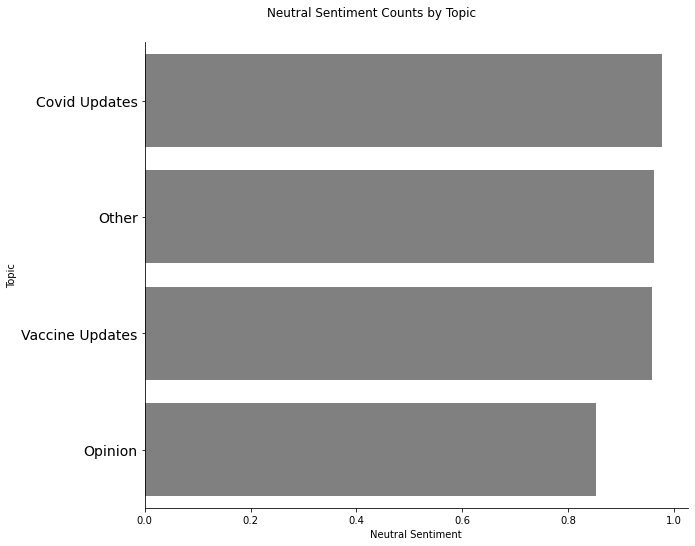

In [33]:
plot=sns.catplot(y='topic',
                 x='neu_p', 
                 kind='bar',
                 data = sent_cnts_topic.sort_values(by=['neu_p'],ascending=False), 
                 color='grey', 
                 height=7,
                 aspect=1.3)
plot.set_yticklabels(fontsize=14)
plot.fig.suptitle('Neutral Sentiment Counts by Topic', y=1.05)
plot.ax.set_xlabel('Neutral Sentiment')
plot.ax.set_ylabel('Topic')
# fig.show()

Without looking at many of the tweets in each topic, my assumptions based on the above graphs is: <br><br>
- That the 'Opinion' topic has tweets that are more subjective and thus more positive and negative. 
- Where the topic 'Vaccine Info' encompassing roll out, distribution, details have more positive sentiment within their topic than say the Pandemic info. Tweets about vaccines 'finally' getting to a certain area or celebrating that they've taken the vaccine. I assume the negative tweets here would be the updates where the vaccine is delayed and/or warning about taking the vaccine are  sorted.
- The topic of Pandemic Info has a lot of negative sentiment tweets within it's topic, but, because the vast majority of tweets in this topic are not as much as 'Opinion' I'm assuming this is because the Pandemic Info are tweets with updates that are less subjective but carry a lot of tweets that carry negative sentiment. Such as 'death' and 'serious illness'.
- It would be interesting to see how objective/subjective each of these topics are
- The non-Opinion topics have a higher % of neutral comments within the topic than the 'Opinion'.

### Investigate levels of subjectivity within each topic

In [34]:
full_data['subjectivity']=full_data.apply(lambda x: 'low' if x['tb_subj']<.2 else ('high' if x['tb_subj']>.45 else 'med'),axis=1) 

In [35]:
sentb_bytopic_dict = defaultdict(list)

sent_vals = {'high','med','low'}

for x, topic in enumerate(full_data.topic_title.unique()):
    cnts = full_data[(full_data.topic_title==topic)].subjectivity.value_counts(normalize=True)
    
    for idx in cnts.index:
        sentb_bytopic_dict[idx+'_p'].append(cnts.loc[idx])
    
    if len(cnts.index)<3:
        for s in sent_vals.difference(set(cnts.index)):
            sentb_bytopic_dict[s+'_p'].append(0)
    
    
    cnts = full_data[full_data.topic_title==topic].subjectivity.value_counts()
    
    for idx in cnts.index:
        sentb_bytopic_dict[idx].append(cnts.loc[idx])
    
    if len(cnts.index)<3:
        for s in sent_vals.difference(set(cnts.index)):
            sentb_bytopic_dict[s].append(0)
    
    sentb_bytopic_dict['topic'].append(topic)

In [36]:
sentb_cnts_topic = pd.DataFrame.from_dict(sentb_bytopic_dict)
display(sentb_cnts_topic)
sentb_cnts_topic.to_csv('subjectivity_by_topic_8t.csv',index=False)
sentb_cnts_topic['topic']=sentb_cnts_topic.topic.astype(str)

,high_p,med_p,low_p,high,med,low,topic
0,0.485295,0.287253,0.227453,12392,7335,5808,Opinion
1,0.349831,0.303501,0.346668,6305,5470,6248,Vaccine Updates
2,0.374751,0.225914,0.399336,564,340,601,Other
3,0.465504,0.199048,0.335448,587,251,423,Covid Updates


Text(-60.325, 0.5, 'Topic')

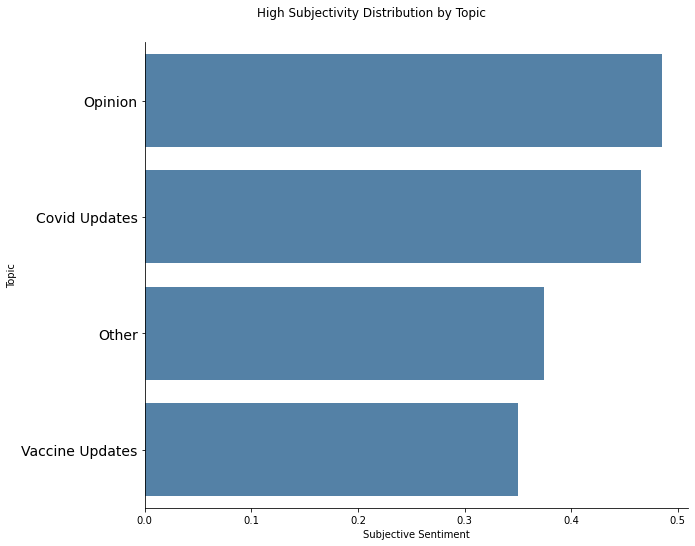

In [37]:
plot=sns.catplot(y='topic',
                 x='high_p', 
                 kind='bar',
                 data = sentb_cnts_topic.sort_values(by=['high_p'],ascending=False), 
                 color='steelblue', 
                 height=7,
                 aspect=1.3)
plot.set_yticklabels(fontsize=14)
plot.fig.suptitle('High Subjectivity Distribution by Topic', y=1.05)
plot.ax.set_xlabel('Subjective Sentiment')
plot.ax.set_ylabel('Topic')
# fig.show()

Text(-60.325, 0.5, 'Topic')

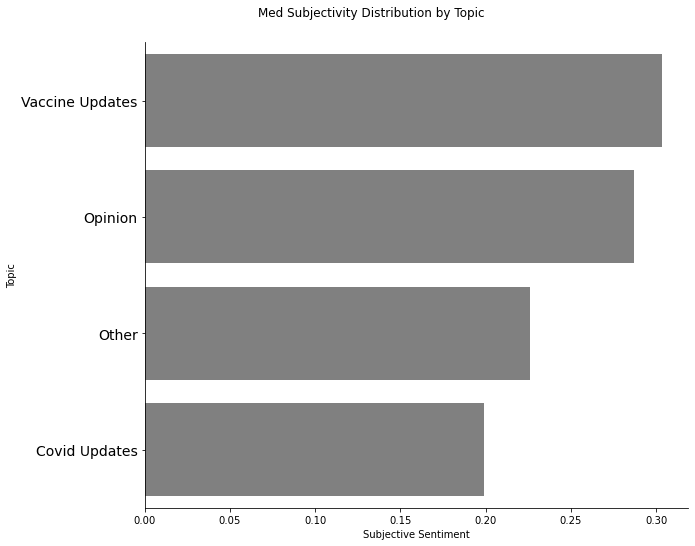

In [38]:
plot=sns.catplot(y='topic',
                 x='med_p', 
                 kind='bar',
                 data = sentb_cnts_topic.sort_values(by=['med_p'],ascending=False), 
                 color='grey', 
                 height=7,
                 aspect=1.3)
plot.set_yticklabels(fontsize=14)
plot.fig.suptitle('Med Subjectivity Distribution by Topic', y=1.05)
plot.ax.set_xlabel('Subjective Sentiment')
plot.ax.set_ylabel('Topic')
# fig.show()

Text(-60.325, 0.5, 'Topic')

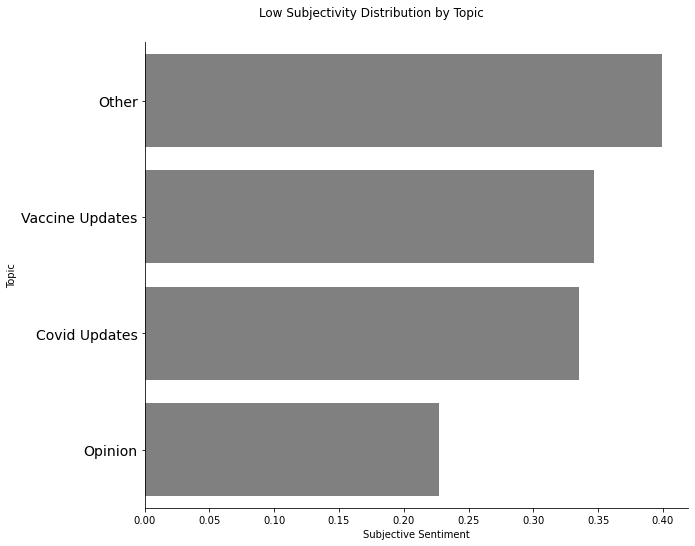

In [39]:
plot=sns.catplot(y='topic',
                 x='low_p', 
                 kind='bar',
                 data = sentb_cnts_topic.sort_values(by=['low_p'],ascending=False), 
                 color='grey', 
                 height=7,
                 aspect=1.3)
plot.set_yticklabels(fontsize=14)
plot.fig.suptitle('Low Subjectivity Distribution by Topic', y=1.05)
plot.ax.set_xlabel('Subjective Sentiment')
plot.ax.set_ylabel('Topic')
# fig.show()

They all have a similar distribution of High/Med/Low subjectivity within each topic.

<Figure size 1080x720 with 0 Axes>

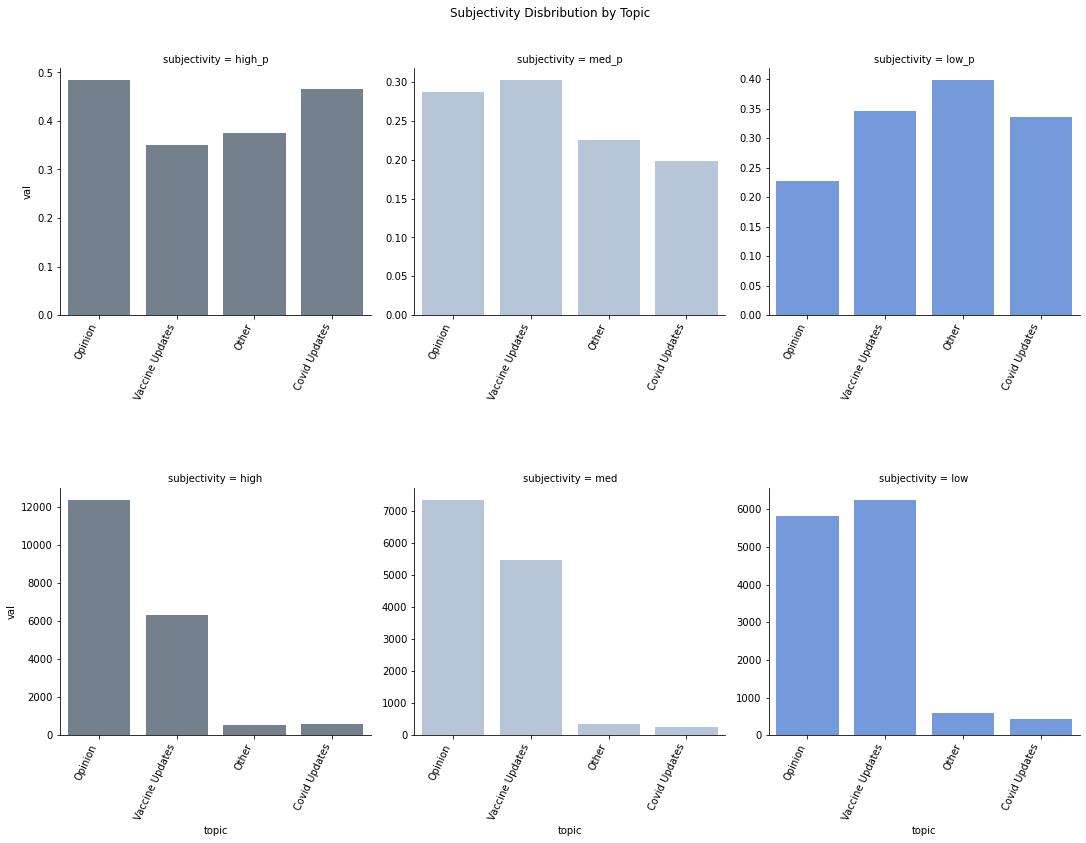

In [40]:

subj_cnts=sentb_cnts_topic.melt('topic', var_name='subjectivity',value_name='val')

plt.figure(figsize=(15,10))
catplot=sns.catplot(y='val',
              x='topic', 
              kind='bar',
              data = subj_cnts,
              hue='subjectivity',
              palette = ['slategrey','lightsteelblue','cornflowerblue']*3,
              col='subjectivity',
              sharey=False,
              sharex=False,
              col_wrap=3,
                   dodge=False)
plt.subplots_adjust(hspace=.7)
catplot.fig.suptitle('Subjectivity Disbribution by Topic', y=1.05)
catplot.set_xticklabels(rotation=65, horizontalalignment='right')



In [41]:
display(sentb_cnts_topic)

,high_p,med_p,low_p,high,med,low,topic
0,0.485295,0.287253,0.227453,12392,7335,5808,Opinion
1,0.349831,0.303501,0.346668,6305,5470,6248,Vaccine Updates
2,0.374751,0.225914,0.399336,564,340,601,Other
3,0.465504,0.199048,0.335448,587,251,423,Covid Updates


<Figure size 1080x720 with 0 Axes>

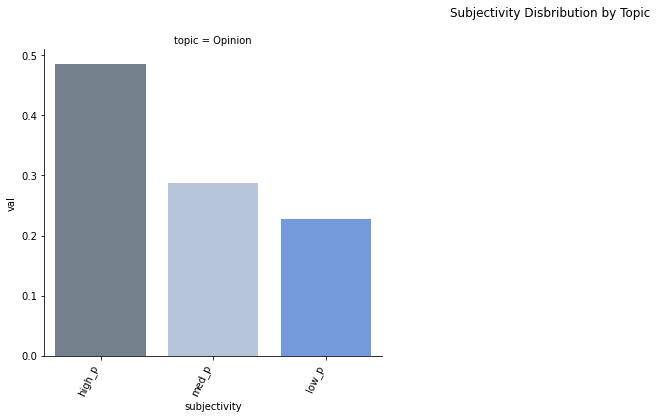

<Figure size 1080x720 with 0 Axes>

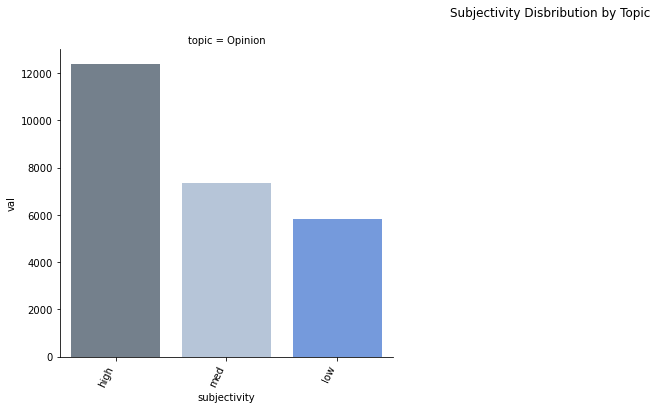

<Figure size 1080x720 with 0 Axes>

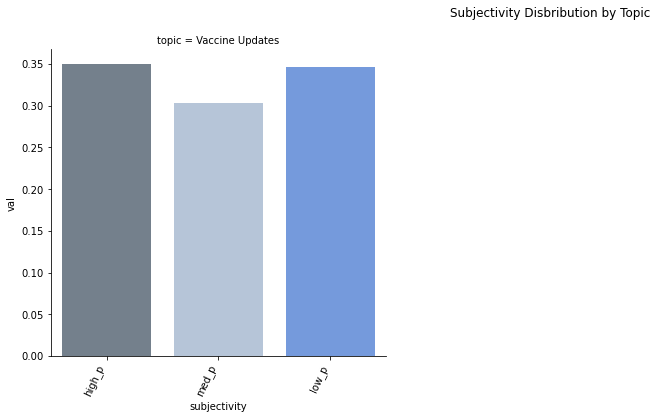

<Figure size 1080x720 with 0 Axes>

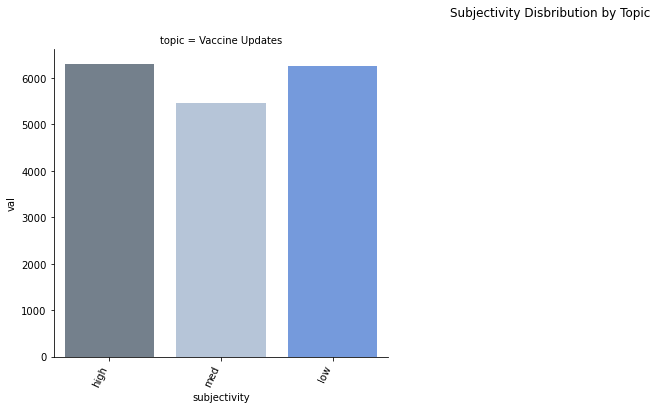

<Figure size 1080x720 with 0 Axes>

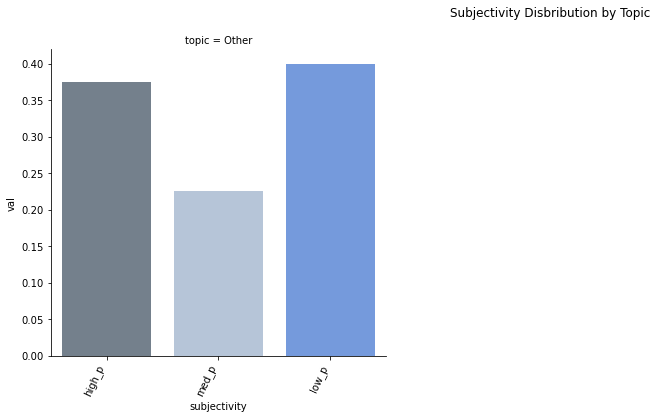

<Figure size 1080x720 with 0 Axes>

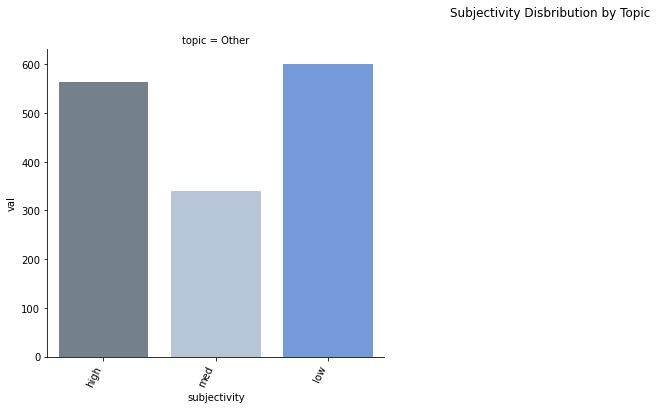

<Figure size 1080x720 with 0 Axes>

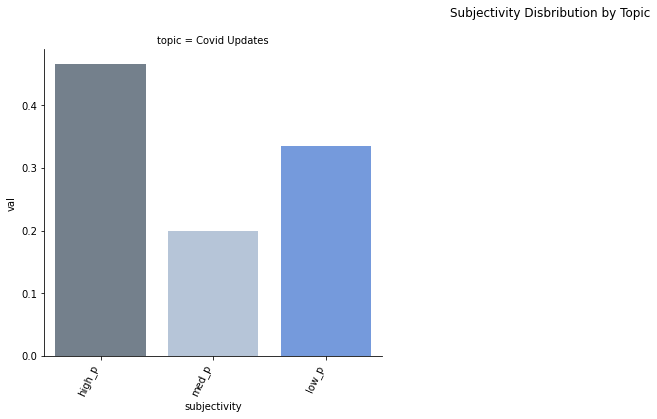

<Figure size 1080x720 with 0 Axes>

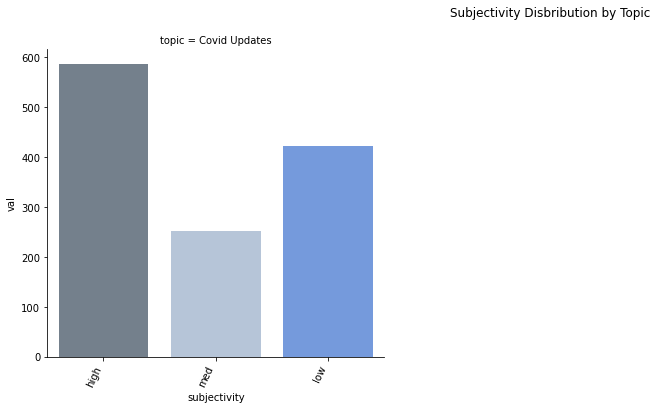

In [42]:
subj_cnts=sentb_cnts_topic.melt('topic', var_name='subjectivity',value_name='val')
vals1 = list(set([x for x in subj_cnts.subjectivity.values if '_' in x ]))
vals2 = list(set([x for x in subj_cnts.subjectivity.values if '_' not in x ]))
for topic in subj_cnts.topic.unique():
    for vals in [vals1, vals2]:
        
    
        plt.figure(figsize=(15,10))
        catplot=sns.catplot(y='val',
                      x='subjectivity', 
                      kind='bar',
                      data = subj_cnts[(subj_cnts.topic==topic) & (subj_cnts.subjectivity.isin(vals))],
                      hue='subjectivity',
                      palette = ['slategrey','lightsteelblue','cornflowerblue']*2,
                      col='topic',
                      sharey=False,
                      sharex=False,
                      col_wrap=3,
                           dodge=False)
        plt.subplots_adjust(hspace=.7)
        catplot.fig.suptitle('Subjectivity Disbribution by Topic', y=1.05)
        catplot.set_xticklabels(rotation=65, horizontalalignment='right')


In [43]:
tw = 3 #tweets to print per sentiment
for s in full_data.subjectivity.unique():
    print('Subjectivity| {}-----------'.format(s))
    for t in full_data.topic_title.unique():
        print('Topic | {}-----'.format(t))
        for sent in full_data.tb_sent.unique():
            print('Sentiment| {}-------\n'.format(sent))
            print('Tweet with --> Topic | Subjectivity | Sentiment')
            print('Tweets with --> {} | {} | {} \n'.format(t,s,sent))
            for i,x in enumerate(full_data[(full_data.topic_title==t)&(full_data.subjectivity==s)&(full_data.tb_sent==sent)].sample(tw).full_text):
                print('Tweet {} of {}--> '.format(i+1,tw),x,)
            print('++++++'*5,'\n\n')
    print('----'*5,'\n\n')

Subjectivity| high-----------
Topic | Opinion-----
Sentiment| pos-------

Tweet with --> Topic | Subjectivity | Sentiment
Tweets with --> Opinion | high | pos 

Tweet 1 of 3-->  How is it possible that after having 2 doses of snake oil all these over 75s are dying of #covid?

Good to see 200,000 sane health care workers not destroying their immune systems
Tweet 2 of 3-->  @AtomsksSanakan @AidanV2now @johnnut43021860 @ClarkeMicah @ryanbourne So you mean that what I am referring to as "immunity" is a very different from what it means for a vaccine to convey immunity to SarsCov2?  Just to be clear so I can understand the point of this.
Tweet 3 of 3-->  @JulieHamill @boogaloo_radio @thevaccines we've been using The Vaccines in our tiktoks! ideal music! #vaccinated https://t.co/8oLKYHkFj6
++++++++++++++++++++++++++++++ 


Sentiment| neu-------

Tweet with --> Topic | Subjectivity | Sentiment
Tweets with --> Opinion | high | neu 

Tweet 1 of 3-->  There is increasing recognition among physic

Topic | Opinion-----
Sentiment| pos-------

Tweet with --> Topic | Subjectivity | Sentiment
Tweets with --> Opinion | med | pos 

Tweet 1 of 3-->  @MirrorBreaking_ @DailyMirror @Highfiver2021 
If the government had to get something right, it's a blessing it's the vaccine roll out. Get vaccinated to protect us all. Help those affected post-pandemic. Get Vax. Give Back. Donate £5 to one of 5 charities at https://t.co/mgoWOydLGj . 5 
#highfiver
#vaxthanks
Tweet 2 of 3-->  Nearly a year after being shut by the #pandemic, cultural institutions are #reopening this week, bringing musicians, comedians, actors, and others back on stage for shows, in front of a live, #vaccinated #audience
https://t.co/aEoydXpu29
Tweet 3 of 3-->  Check out this eye-opening graph from @GOPLeader that highlights just how little of the Dem’s so-called COVID relief bill will actually help combat the coronavirus. Over 90% of this bill goes towards enacting President Biden’s political priorities, not helping those in n

Tweet 1 of 3-->  We are officially at the stage of vaccination where no one cares if you got a vaccine.

In fact, it may even make people jealous.

Just take your shot and shut your trap.

#vaccine #vaccinated #Pfizer #moderna
Tweet 2 of 3-->  PETITION: No to mandatory vaccination for the coronavirus https://t.co/AiX8h2qs1S
Tweet 3 of 3-->  @naomirwolf @SamPancher @srauer20 @pfizer And just for the record, his son blamed China for this pandemic disease which is SO racist (like his father). He is a conspiracist fascist.
++++++++++++++++++++++++++++++ 


Topic | Vaccine Updates-----
Sentiment| pos-------

Tweet with --> Topic | Subjectivity | Sentiment
Tweets with --> Vaccine Updates | low | pos 

Tweet 1 of 3-->  AstraZeneca Plc has sold its stake in Moderna Inc for more than $1 billion after the American biotechnology company's shares soared on the back of its coronavirus vaccine breakthrough, The Times reported.
Tweet 2 of 3-->  Why does the Chinese vaccine boost corona cases and deat

The subjectivity did a pretty good job of segmenting out low subjectivity comments, such as updates. The sentiment could be tweaked to improve the sentiment of the tweet due to sarcasm and negation. <br><br>
Looking at this data, I believe the next step is to take all highly subject tweets, to filter out updates about coronavirus and vaccines and perform another topic modeling to find out what topics people are being subjective about. It may even produce better results to perform this modeling on all Highly Subjective AND Positive or Negative sentiments to see what topics people are most positive and/or negative about.

### Take a look at defining positive/negative a different way
By changing the cut offs for positive and negative sentiment

In [44]:
sent_df=full_data[full_data.columns[-13:]]

In [45]:
sent_df.head(2)

,neu_sentiment,pos_sentiment,compound_sentiment,neg_sent,neu_sent,pos_sent,compound_sent,tb_score,tb_subj,tb_sent,tb_sent_subj,v_sent,subjectivity
0,0.676,0.210,0.6124,0.114,0.676,0.210,0.6124,0.233333,0.766667,pos,pos,pos,high
1,0.837,0.163,0.7041,0.000,0.837,0.163,0.7041,0.000000,0.500000,pos,neu,pos,high


Notes: There will require a lot more time digging into classifying what is 'positive' and what is 'negative'. I believe the subjectivity feature will be highly valuable in learning what regular folks feel.<br><br> 
Take a look below. I have printed 'positive' tweets, that are highly subjective. Though the majority are negative and sarcastic.

### Positive

In [46]:
# using textblob subjectivity and positive sentiment sorted by vader compound sentiment
idxs=sent_df[(sent_df.tb_subj>.5)&(sent_df.tb_sent_subj=='pos')].sort_values(by='compound_sent',ascending=False).index.tolist()[:5]
[print(x,'\n----\n') for x in full_data.iloc[idxs].full_text.tolist()]

@ashlieatkinson Yes your that worried about your health you don’t mind wearing a mask but you don’t care about stuffing your face. Good luck getting an experimental vaccine. Good luck sweetheart. #NoVaccine 
----

Medicine has this bias where you can't do anything unless you're super super super super sure it's not bad. A pandemic requires bolder decision making. It's pretty clear to me, a layperson, that we should get first doses into as many people as possible first. https://t.co/yco6v7urwz 
----

@PFr1end @Nicole86201389 @endtimeslife As a Christian taking the vax is like having experimental plastic surgery done but in reverse. God's protect me from the virus by giving me an amazing immune system that can deal perfectly w/it. I will not be vaccinated! May my Lord Yeshua judge. In Him alone I trust. Luke 12:7🛐 https://t.co/KmoWW6idyW 
----

@joqween @ColorsOfTheWi13 DEAR TEXANS: Because you —
are tough
are fighters
love freedom
love life
PLEASE CONTINUE TO —
wear your mask
wash your 

[None, None, None, None, None]

The following are tweets with a slightly different filter. It's highly subject and highly positive according to textblob.<br><br>

It's interesting that these speak to education of vaccines or the progress of tackling the pandemic

In [47]:
# using textblob subjectivity and positive sentiment sorted by textblob score
idxs=sent_df[(sent_df.tb_subj>.5)&(sent_df.tb_score>.5)].sort_values(by='tb_score',ascending=False).index.tolist()[:5]
[print(x,'\n----\n') for x in full_data.iloc[idxs].full_text.tolist()]

F YOU COVID! You've murdered relatives, friends, 500K in the USA. Hypocrisy to blame someone for no national policy, if I don't do my part. Excellent job by @alabamastateu for the vaccines. Dr. Joyce in control. #COVID19Vaccine #MyASU #pandemic #pfizer #RollUpSleeve https://t.co/aIZ1Vhieju 
----

Thank you @NSSD112 for taking care of your staff and getting us vaccinated against #COVID19 (TY to @Walgreens for your service this AM &amp; @DPS109 for providing the space)!! Grateful and proud to be a 112 staff member! #112leads #vaccine #vaccinated https://t.co/U2IFMRykCu 
----

@BorisJohnson @Young_Tories https://t.co/nWVQBhWY75
whilst giving us #herdimmunity and 121,747 deaths + with #coronavirus #COVID19 
#priceless 
----

Happy Client!
.
.
.
#Eatfit247 #happyclient #healthylife #healthgoals #health #weightloss #diet #dietplans #skinandhair #immunity #cleaneating #goodhealth https://t.co/BoE1uA120w 
----

Happy Immunization Day!

✅

#Immunity #immunization #COVID19Vaccine #COVID19Ontario

[None, None, None, None, None]

The following are tweets were tweaked a bit further. It's highly subject and highly positive according to vader sentiment. It's the same as above, only ranked by vader sentiment compound score, cutoffs were the same.<br><br>

There is a possibility that some of these are not referring to the pandemic, but were picked up originally for words like 'virus', not in the context of the covid-19 pandemic.<br><br>
With that said - it's interesting that these focus on fun activities & family time/experiences despite or due to the pandemic.

In [48]:
# using textblob subjectivity and a different textblob positive sentiment cutoff sorted by vader compound sentiment
idxs=sent_df[(sent_df.tb_subj>.5)&(sent_df.tb_score>.5)].sort_values(by='compound_sent',ascending=False).index.tolist()[:5]
[print(x,'\n----\n') for x in full_data.iloc[idxs].full_text.tolist()]

Congrats to @ericbouck and @Robsaysthings for the launch of @HedgehogTrivia! I've been on many games -- great hosts, great questions, super fun and entertaining. Great way to facilitate team bonding!! https://t.co/pnGqseJo4X #WFH #COVID19 #teamfun 
----

@SunlitS_J  you’ve had some lovely videos from some lovely people today, I bet Jack is really happy that Captain Seb was there for him this morning. I’m proud of you both for bringing everyone together in this pandemic, &amp; for being a great friend. Thank you. 🤗🤗 for Jack. 
----

Happiest Birthday to our dork yet cool brave man! Thank you for being our happy virus. Thank you for sharing your talent to all of us. May you continue to shine like a star! Yejiapsa, mochi!💙 
Your Omega, J.
@OFFICIALBTOB @LeeCS_BTOB
#BORN_TO_BE_CHANGSUB 
https://t.co/CSeCqsg8ra 
----

🍊Defense Boost Vitamin C Gummies are crafted with a delicious flavor and vital nutrients and antioxidants to help encourage optimal wellness and support your immune system.

#

[None, None, None, None, None]

### Negative

Same as above, but fliped for negative sentiments

Side note - I've seen 'asian american' terms come up. It would be interesting to see how that term trends over time due to the pandemic

A pretty good mix of the most negative tweets. It seems to be negative sentiment around politics, the disruption of the pandemic, racism, anti-vaxers. It seems to be more of the same topics in the news today.

An interesting find though ... some of the 'positive' sentiments above could gain more insight into what folks 'feel' or think about a vaccine. For example, if a person who is not into taking vaccine, would not talk negativley about not taking the vaccine. They would say how their decision is good, and explain why. It may be worth it to do more EDA into neg vs positive to find these nuances.

In [49]:
idxs=sent_df[(sent_df.tb_subj>.5)&(sent_df.tb_sent_subj=='neg')].sort_values(by='compound_sent',ascending=True).index.tolist()[:5]
[print(x,'\n----\n') for x in full_data.iloc[idxs].full_text.tolist()]

Marxism.... Max stress 
Fake news
Fake pandemic
Fake elections.
Fake president
Fake white supremacy
Fake extremism
Fake Trump insurrection
Fake Kamala not afr amer
Fake climate change
Fake Biden Healing 
Fake Vax https://t.co/48Y2W7FDr7 
----

@GOP Trump’s d worst POTUS &amp; most incompetent ever! Shameless &amp; biggest loser incumbent ever! A pathological liar, racist &amp; unstable! Narcissist, traitor, Insurrectionist, dishonorable, d most corrupt &amp; amoral! He’s vaccinated secretly while lying to his stupid supporters about covid 
----

The vax seeks to reduce costs of Covid, but how much weight to give to hospitalizations and death, how much to economic disruptions, how much to devastating harm faced by our children? I never imagined that the that % chance of death by age would be the only thing that matters. 
----

I hate these anti-vaxers like bitch you really just wanna die even though you’ve been vaxed your whole life? Idk stop changing shit also why now? You sound stupid

[None, None, None, None, None]

In [50]:
idxs=sent_df[(sent_df.tb_subj>.5)&(sent_df.tb_score<.5)].sort_values(by='tb_score',ascending=True).index.tolist()[:5]
[print(x,'\n----\n') for x in full_data.iloc[idxs].full_text.tolist()]

@AP People I know have been suffering horribly from these vaccines.  They say they would rather catch it than take the vaccination ever 
----

This is freaking insane.  #firefauci https://t.co/llHdGMcv6d 
----

I am insanely relieved... dose 1 of @pfizer #covid #vaccination done! https://t.co/LcPQVfHOzD 
----

@RepKClark @WhipClyburn Unlock the cities from ur insane Wuhan virus program of destruction, &amp; pass policies which promote jobs! 
----

US Covid-19: After a devastating milestone, vaccine makers pledge hundreds of millions of doses through July - CNN https://t.co/IGvmUiK9Z7 
----



[None, None, None, None, None]

This below filter is similar to the first one

In [51]:
idxs=sent_df[(sent_df.tb_subj>.5)&(sent_df.tb_score<.5)].sort_values(by='compound_sent',ascending=True).index.tolist()[:5]
[print(x,'\n----\n') for x in full_data.iloc[idxs].full_text.tolist()]

Marxism.... Max stress 
Fake news
Fake pandemic
Fake elections.
Fake president
Fake white supremacy
Fake extremism
Fake Trump insurrection
Fake Kamala not afr amer
Fake climate change
Fake Biden Healing 
Fake Vax https://t.co/48Y2W7FDr7 
----

@CSandbox @DrDooleyMD I hate 2 say it but hypothesis of various doctors / evidence oFMANDATORY FLU VAX stats from MILITARY show u got flu shot &amp; u hv higher % get sick w covid19 disease not SARS COV2! Italians had highest population OLD FOLKS ESP of lethal FLU VAX &amp; worst covid19 disaster! All connecT 
----

@GOP Trump’s d worst POTUS &amp; most incompetent ever! Shameless &amp; biggest loser incumbent ever! A pathological liar, racist &amp; unstable! Narcissist, traitor, Insurrectionist, dishonorable, d most corrupt &amp; amoral! He’s vaccinated secretly while lying to his stupid supporters about covid 
----

@BekahTheBold @Lui_101499 @WSJ No. I'm saying y would a 58 yr old just drop dead "coincidentally" after a Covid vax. She's not the

[None, None, None, None, None]

## Which twitter users were most positive / negative?

In [52]:
sent_byuser_dict = defaultdict(list)

sent_vals = {'neu','pos','neg'}

for x, user in tqdm(enumerate(full_data.user_id.unique())):
    cnts = full_data[full_data.user_id==user].tb_sent_subj.value_counts(normalize=True)
    
    for idx in cnts.index:
        sent_byuser_dict[idx+'_p'].append(cnts.loc[idx])
    
    if len(cnts.index)<3:
        for s in sent_vals.difference(set(cnts.index)):
            sent_byuser_dict[s+'_p'].append(0)
    
    
    cnts = full_data[full_data.user_id==user].tb_sent_subj.value_counts()
    
    for idx in cnts.index:
        sent_byuser_dict[idx].append(cnts.loc[idx])
    
    if len(cnts.index)<3:
        for s in sent_vals.difference(set(cnts.index)):
            sent_byuser_dict[s].append(0)
    
    sent_byuser_dict['user'].append(user)

<ipython-input-52-15e240dd1237>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x, user in tqdm(enumerate(full_data.user_id.unique())):


0it [00:00, ?it/s]

In [53]:
sent_cnts_users = pd.DataFrame.from_dict(sent_byuser_dict)
sent_cnts_users['user']=sent_cnts_users.user.apply(lambda x: str(int(x)))
display(sent_cnts_users.head(2))
sent_cnts_users.to_csv('sentiment_user_counts_8t.csv',index=False)

,pos_p,neu_p,neg_p,pos,neu,neg,user
0,1.0,0.0,0.0,1,0,0,29501253
1,0.0,1.0,0.0,0,3,0,1201670995435646976


Text(-98.325, 0.5, 'Users')

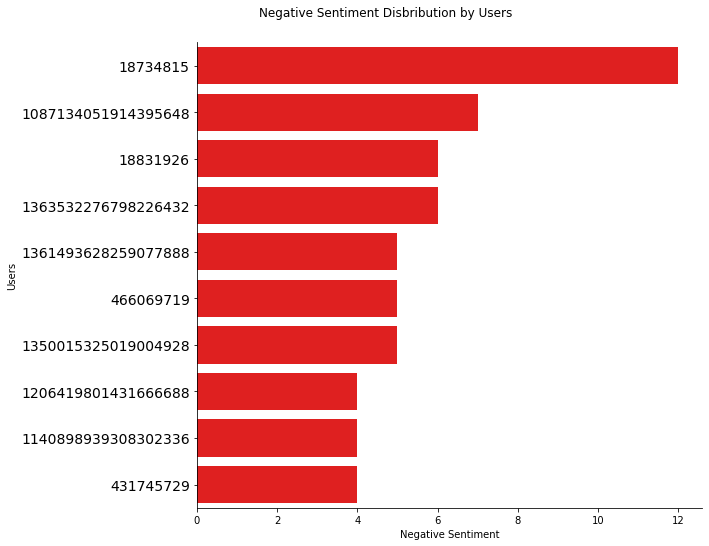

In [54]:
plot=sns.catplot(y='user',
                 x='neg', 
                 kind='bar',
                 data = sent_cnts_users.sort_values(by=['neg'],ascending=False)[:10], 
                 color='red', 
                 height=7,
                 aspect=1.3)
plot.set_yticklabels(fontsize=14)
plot.fig.suptitle('Negative Sentiment Disbribution by Users', y=1.05)
plot.ax.set_xlabel('Negative Sentiment')
plot.ax.set_ylabel('Users')
# fig.show()

Twitter Ids have been removed

18734815 => removed <br>
1199283206547095552 => removed <br>
466069719 => removed <br>
1087134051914395648 => removed<br>
1359853845682278400 => Error: Not Found*<br>
1324329792867602432 => Error: Not Found*<br>
18831926 => removed<br>
1363532276798226432 => Error: Not Found*<br>
17353325 => removed<br>
18868445 => removed<br>
<br><br><br>
These user ids did not return a value. It could be that this user deleted their account, or, during wrangling python has rounded the user id variable while it was a number, making the number different

#### 5 of the negative tweets from @24AheadDotCom

In [55]:
[print(x) for i,x in enumerate(full_data[full_data.user_id==18734815][:5].full_text) if full_data[(full_data.user_id==18734815)].iloc[i].tb_sent_subj=='neg']

@AaliaAnthony @HildaSolis @Cleavon_MD @LACDevAuthority @Curative @lapublichealth 95% of C19 deaths were 50+ &amp; risk factors play a major role. Vax them &amp; there's basically no more pandemic.

Instead, @HildaSolis wants to vax young/healthy people of the "right race" before seniors/high risk of the "wrong race" because she's David Duke with a tan.
@m2angels2 @luna_c_is_here @GavinNewsom The solution is simple: vax by ICU risk. Cover seniors/high risk - those most likely to die - and the spread doesn't matter.

@GavinNewsom is going about it backwards: vaxing young/healthy before seniors/high risk. That increases deaths &amp; prolongs the pandemic.
@TexasDoctorCool @SenToniAtkins @GavinNewsom The problem is with con leaders. Newsom is extremely vulnerable on his vax tiers that are prolonging the pandemic &amp; increasing deaths.

Instead of harping on that, con leaders act like their kids &amp; whine about school sports as Newsom is literally killing people.


[None, None, None]

#### 5 of the negative tweets from @stefan90671458

In [56]:
[print(x) for i,x in enumerate(full_data[full_data.user_id==1199283206547095552][:5].full_text) if full_data[(full_data.user_id==18734815)].iloc[i].tb_sent_subj=='neg']

The world round us wil be made to coerce us into taking Phizers DNA🧬Rna vax. Public transport,favorite events,restaurants,workplaces,travel etc &amp; for what a virus that has 99.997% recovery rate 900 dead/26,000,000, u have more of chance of dying in car accident 1500 dead 2019🇦🇺
@theheraldsun The world round us will be made to coerce us into taking Phizers DNA🧬Rna vax. Public transport,favorite events,restaurants, workplaces,travel etc &amp; for what a virus that has 99.997% recovery rate 900 dead/26,000,000, u have more of chance of dying in car accident 1500 dead 2019!


[None, None]

Text(-98.325, 0.5, 'Users')

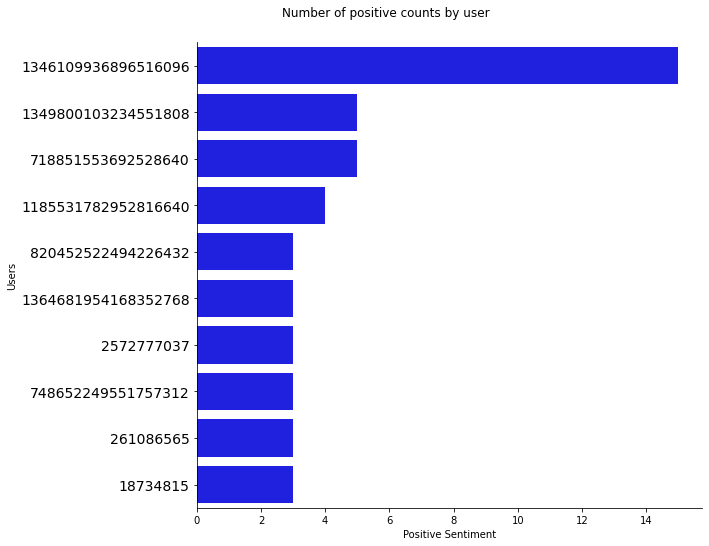

In [57]:
plot=sns.catplot(y='user',
                 x='pos', 
                 kind='bar',
                 data = sent_cnts_users.sort_values(by=['pos'],ascending=False)[:10], 
                 color='blue', 
                 height=7,
                 aspect=1.3)
plot.set_yticklabels(fontsize=14)
plot.fig.suptitle('Number of positive counts by user', y=1.05)
plot.ax.set_xlabel('Positive Sentiment')
plot.ax.set_ylabel('Users')
# fig.show()

In [58]:
[print(str(int(i))) for i in sent_cnts_users.sort_values(by=['pos'],ascending=False)[:10].user]

1346109936896516096
1349800103234551808
718851553692528640
1185531782952816640
820452522494226432
1364681954168352768
2572777037
748652249551757312
261086565
18734815


[None, None, None, None, None, None, None, None, None, None]

In [59]:
[print(x) for i,x in enumerate(full_data[full_data.user_id==1178417352511127552][:5].full_text) if full_data[(full_data.user_id==1178417352511127552)].iloc[i].tb_sent_subj=='pos']

@CPAC Our entire country has been screwed thanks to #Trump 
#TrumpKnewAndDidNothing 
He denied the virus &amp; the science, he put our country far behind &amp; held super spreader events. The USA makes up 4% of the world's population but 25% of #COVID19 cases/deaths 😪 in the richest country!
@BillyDStarchild Our entire country has been screwed thanks to #Trump 
#TrumpKnewAndDidNothing 
He denied the virus &amp; the science, he put our country far behind &amp; held super spreader events. The USA makes up 4% of the world's population but 25% of #COVID19 cases/deaths 😪 in the richest country!


[None, None]

The above person with the most positive tweets shows a couple things.
The suppports that more work is needed to define 'positive' and 'negative'. The above tweets I would characterize as negative / sarcastic. <br>
Also - It looks like either this person retweeted or tweeted the same post multiple times to show his passion on the subject, or, there are multiple tweets in the dataset

In [60]:
[print(x) for i,x in enumerate(full_data[full_data.user_id==3291683682][:5].full_text) if full_data[(full_data.user_id==3291683682)].iloc[i].tb_sent_subj=='pos']

@deNutrients Significant clinical  benefits 
https://t.co/o3GI3to7CG
https://t.co/7Bj66Lz2H4 
https://t.co/hDAFUf2d47 
Over-the-Counter prevention &amp; therapy
https://t.co/qchnVb7SqH
Vitamin D &amp; Quercetin inhibit viral entry &amp; Vitamin D+ QCT + Estradiol interfere with 26/27 (96%) virus proteins


[None]

verify that the above are different tweets, different tweet ids

In [61]:
print('count of this post, posted at different times: ',full_data[(full_data.user_id==3291683682)&(full_data.tb_sent_subj=='pos')].created_at.nunique())
print('number of different tweet ids: ',full_data[(full_data.user_id==3291683682)&(full_data.tb_sent_subj=='pos')].tweet_id.nunique())

count of this post, posted at different times:  1
number of different tweet ids:  1


In [62]:
sent_cnts_users.sort_values(by=['pos'],ascending=False)[:10]

,pos_p,neu_p,neg_p,pos,neu,neg,user
3916,0.365854,0.634146,0.000000,15,26,0,1346109936896516096
1091,0.384615,0.615385,0.000000,5,8,0,1349800103234551808
30479,1.000000,0.000000,0.000000,5,0,0,718851553692528640
1272,0.067797,0.915254,0.016949,4,54,1,1185531782952816640
1048,0.230769,0.538462,0.230769,3,7,3,820452522494226432
10216,1.000000,0.000000,0.000000,3,0,0,1364681954168352768
2250,0.230769,0.692308,0.076923,3,9,1,2572777037
3591,0.750000,0.250000,0.000000,3,1,0,748652249551757312
1735,1.000000,0.000000,0.000000,3,0,0,261086565
3942,0.103448,0.482759,0.413793,3,14,12,18734815


In [65]:
full_data.to_csv(data_path+'\\'+'complete_data_4t.csv',index=False)